In [77]:
import mysql.connector 
import numpy as np
import pandas as pd
import config_final
import requests

from sodapy import Socrata
import sqlalchemy as db


import config_final as config
from schema import DbSchema

import matplotlib.pyplot as plt
import pickle


In [78]:
bills_db = DbSchema(config)


In [79]:
#Query all titles and Passing

df = bills_db.query("""
    SELECT
        *
    FROM con_bills.current_bills as cb
    JOIN con_bills.topics as tp
    ON cb.BillID = tp.BillID
    WHERE cb.Cong >=110
    """)
df.head()

,BillID,BillType,Chamber,Cong,Cosponsr,IntrDate,Mult,PLaw,Title,Veto,...,PLawNum,ImpBill,Majority,Major,Minor,URL,Summary,Index,BillID,dominant_topic
0,110-HR-1,hr,0,110,205.0,2007-01-05 00:00:00,1,1,To provide for the implementation of the recom...,0,...,Became Public Law No: 110-53.,1,1,16.0,1615.0,https://www.congress.gov/bill/110th-congress/h...,Implementing Recommendations of the 9/11 Commi...,1,110-HR-1,5
1,110-HR-10,hr,0,110,0.0,2007-01-04 00:00:00,0,0,Reserved for Speaker.,0,...,0,1,1,20.0,2002.0,https://www.congress.gov/bill/110th-congress/h...,,2,110-HR-10,10
2,110-HR-100,hr,0,110,10.0,2007-01-04 00:00:00,0,0,To amend the Higher Education Act of 1965 to p...,0,...,0,1,1,6.0,601.0,https://www.congress.gov/bill/110th-congress/h...,Veterans' Equity in Education Act of 2007 - Am...,3,110-HR-100,4
3,110-HR-1000,hr,0,110,286.0,2007-02-12 00:00:00,0,0,To award a congressional gold medal to Edward ...,0,...,0,0,1,20.0,2006.0,https://www.congress.gov/bill/110th-congress/h...,Edward William Brooke III Congressional Gold M...,4,110-HR-1000,10
4,110-HR-1001,hr,0,110,0.0,2007-02-12 00:00:00,0,0,To amend the Haitian Hemispheric Opportunity t...,0,...,0,1,1,19.0,1921.0,https://www.congress.gov/bill/110th-congress/h...,Amends the Caribbean Basin Economic Recovery A...,5,110-HR-1001,5


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51067 entries, 0 to 51066
Data columns (total 32 columns):
BillID            51067 non-null object
BillType          51067 non-null object
Chamber           51067 non-null int64
Cong              51067 non-null int64
Cosponsr          51067 non-null float64
IntrDate          51025 non-null object
Mult              51067 non-null int64
PLaw              51067 non-null int64
Title             51067 non-null object
Veto              51067 non-null int64
Class             51067 non-null float64
District          51067 non-null float64
FrstConH          51067 non-null float64
FrstConS          51067 non-null float64
Gender            51067 non-null int64
MRef              51067 non-null int64
NameFull          51067 non-null object
Party             51067 non-null float64
Postal            51067 non-null object
PassH             51067 non-null int64
PassS             51067 non-null int64
PLawDate          1393 non-null object
PLawNum        

**Exploration by Party and Topics**

In [81]:
#rename the 'Party' column using map function
new_labels = {100.0: "Dem", 200.0: "Rep", 328.0: "Third"}

df['Party'] = df['Party'].map(new_labels)  

In [82]:
df['Party'].head()

0    Dem
1    Dem
2    Dem
3    Dem
4    Dem
Name: Party, dtype: object

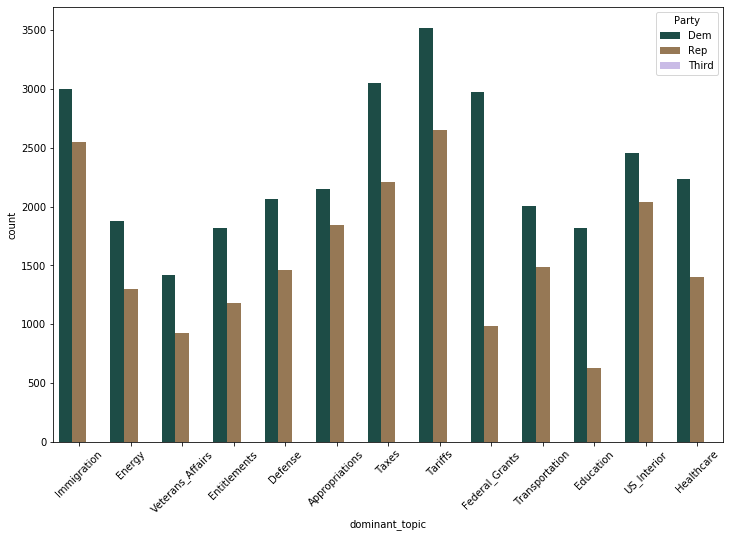

In [83]:
#Using countpoint to see total introductions for each bill topic type by party
#Includes all congresses

import seaborn as sns

plt.figure(figsize=(12,8))
sns.countplot(x='dominant_topic', hue='Party', data=df, palette='cubehelix')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12], ['Immigration', 'Energy', 'Veterans_Affairs', 'Entitlements', 'Defense', 'Appropriations', 'Taxes', 'Tariffs', 'Federal_Grants',  'Transportation', 'Education', 'US_Interior', 'Healthcare'], rotation = 45)
plt.show()

In [84]:
#rename the 'topic' column using map function

new_topic_labels = {1: 'Immigration', 2: 'Energy', 3: 'Veterans_Affairs', 4: 'Entitlements', 5: 'Defense', 6:'Appropriations', 7:'Taxes', 8:'Tariffs', 9:'Federal_Grants',  10:'Transportation', 11:'Education', 12:'US_Interior', 13:'Healthcare'}


df['dominant_topic'] = df['dominant_topic'].map(new_topic_labels) 

In [85]:
df['dominant_topic'].head()

0           Defense
1    Transportation
2      Entitlements
3    Transportation
4           Defense
Name: dominant_topic, dtype: object

**Setting Up data type for Modeling**

To run the model:
- Data must be a pandas dataframe or numpy array
- Data features CANNOT be categorical for KNN
- There must be NO MISSING VALUES in the data

In [86]:
type(df['dominant_topic'])


pandas.core.series.Series

In [91]:
#Data needs to be either in a numpy array or dataframe and cannot must be shaped
#Select specific columns using double brackets

data = df[['Cosponsr']]

In [92]:
#convert to numpy array

target = df['Party'].to_numpy(dtype=None)

In [98]:
#The data itself must have at least one column of continuous data
#The target should be a single row array
#They should BOTH have exactly the same number of rows

print(data.shape)
print(target.shape)

(51067, 1)
(51067,)


In [120]:
#If we wanted to use all the columns present, X and y could be set like this:

y = df['Party'].values
X = df.drop('Party', axis=1).values

**Quick Party Predictor using KNN:**


In [99]:
from sklearn.neighbors import KNeighborsClassifier

#instantiate the classifier
knn = KNeighborsClassifier(n_neighbors=6)

#Pass it the data and the target as arguments
knn.fit(data, target)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

**Making a Prediction using KNN:**

In [116]:
#Here we will just take this random rample for the sake of this exercise

sample_set = data.sample(30)

sample_set.shape

(30, 1)

In [115]:
#The datatype needs to match that of the testing data passed into the model. Here a dataframe is passed in that matches the dimensions.

prediction = knn.predict(sample_set)

In [118]:
#The prediction shape should match the shape of the sample_set above
#Each row is a 'prediction' of the party for each item in the sample

prediction.shape

(30,)

In [119]:
print(f'Predictions: {prediction}')

Predictions: ['Dem' 'Dem' 'Dem' 'Dem' 'Dem' 'Dem' 'Dem' 'Rep' 'Dem' 'Dem' 'Dem' 'Dem'
 'Dem' 'Dem' 'Dem' 'Dem' 'Rep' 'Dem' 'Dem' 'Dem' 'Dem' 'Dem' 'Dem' 'Dem'
 'Dem' 'Dem' 'Dem' 'Dem' 'Dem' 'Dem']
